# Create a naive convnet model to classify images of horses and humans
The model used in this notebook is the same used in the Google Colab notebook as it appears in [Course 1 - Part 8 - Lesson 2](https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/Course%201%20-%20Part%208%20-%20Lesson%202%20-%20Notebook.ipynb#scrollTo=rX8mhOLljYeM)

In [1]:
library(checkmate)

In [2]:
cur.dir <- getwd()
data.dir <- file.path(cur.dir, "data", "original-train")
horses.dir <- file.path(data.dir, "horses")

# Check to see if files have been downloaded
Otherwise call the script that does it

In [3]:
if (checkDirectoryExists(horses.dir) == TRUE) {
  f.lst <- list.files(horses.dir) 
  if (length(f.lst) < 500)
    source("wrangle-files.R")
}

In [4]:
rm(data.dir, horses.dir)

# Separate the data into train, validation and test

In [5]:
data.horses.dir <- file.path(cur.dir, "data", "all-horses")

if (checkDirectoryExists(data.horses.dir) == TRUE) {
  f.lst <- list.files(data.horses.dir) 
  if (length(f.lst) < 628)
    source("aggregate-files.R")
}

In [6]:
rm(cur.dir, data.horses.dir)

In [7]:
cur.dir <- getwd()
train.horses.dir <- file.path(cur.dir, "data", "train", "horses")

# Check to see if files have been aggregated
Otherwise call the script that does it

In [8]:
if (checkDirectoryExists(train.horses.dir) == TRUE) {
  f.lst <- list.files(train.horses.dir) 
  if (length(f.lst) < 439)
    source("split-files.R")
}
rm(cur.dir,train.horses.dir)

# Building the network using a seed to guarantee reproducible
The latest Keras API implementation raises an error (shown below) when trying to set a seed for the session. Thus as of the date of this writing this is disabled. 

    Error in py_get_attr_impl(x, name, silent): AttributeError: module 'tensorflow_core.keras.backend' has no attribute 'set_session'

In [9]:
library(keras)
keras::k_clear_session()
#use_session_with_seed(seed = 2941, disable_gpu = TRUE)

In [10]:
model <- keras_model_sequential() %>%
  layer_conv_2d(filters = 16, kernel_size = c(3, 3), activation = "relu",                
                input_shape = c(300, 300, 3)) %>%  
  layer_conv_2d(filters = 32, kernel_size = c(3, 3), activation = "relu",                
                input_shape = c(300, 300, 3)) %>%  
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%  
  layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = "relu") %>%  
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%  
  layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = "relu") %>%  
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%  
  layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = "relu") %>%  
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%  
  layer_flatten() %>%  
  layer_dense(units = 512, activation = "relu") %>%  
  layer_dense(units = 1, activation = "sigmoid")

summary(model)

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d (Conv2D)                     (None, 298, 298, 16)            448         
________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, 296, 296, 32)            4640        
________________________________________________________________________________
max_pooling2d (MaxPooling2D)        (None, 148, 148, 32)            0           
________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, 146, 146, 64)            18496       
________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)      (None, 73, 73, 64)              0           
________________________________________________________________________________
conv2d_3

Compile the model.

In [11]:
model %>% compile(  loss = "binary_crossentropy",  
                    optimizer = optimizer_rmsprop(lr = 1e-4),  
                    metrics = c("acc"))


Prepare the scaling and create the generator to call the model fit Keras API.

In [12]:
train_datagen <- image_data_generator(rescale = 1/255)
validation_datagen <- image_data_generator(rescale = 1/255)

cur.dir <- getwd()

train_generator <- flow_images_from_directory(  file.path(cur.dir, "data", "train"),
                                                generator = train_datagen,         99  
                                                target_size = c(300, 300), 
                                                batch_size = 20,
                                                color_mode = "rgb",
                                                class_mode = "binary")

validation_generator <- flow_images_from_directory(  file.path(cur.dir, "data", "validation"),
                                                     generator = validation_datagen,
                                                     target_size = c(300, 300),  
                                                     batch_size = 20,  
                                                     color_mode = "rgb",
                                                     class_mode = "binary")


# Train the model using generators

In [13]:
history <- model %>% fit_generator(  train_generator,  
                                     steps_per_epoch = 50,  
                                     epochs = 10,  
                                     validation_data = validation_generator,
                                     validation_steps = 10)


# Save the model and weights

In [14]:
models.dir <- file.path(cur.dir, "models")
model.weights.dir <- file.path(cur.dir, "model-weights")

# do a check to see if the modeld directory exists
if (checkDirectoryExists(models.dir) != TRUE) {
  dir.create(models.dir)
}

if (checkDirectoryExists(model.weights.dir) != TRUE) {
  dir.create(model.weights.dir)
}

In [17]:
model %>% save_model_hdf5(file.path(models.dir, "horses_vs_humans_Moroney2.h5"))
model %>% save_model_weights_hdf5(file.path(model.weights.dir, "horses_vs_humans_wgts_Moroney2.h5"))

# Plot the training history with validation

`geom_smooth()` using formula 'y ~ x'



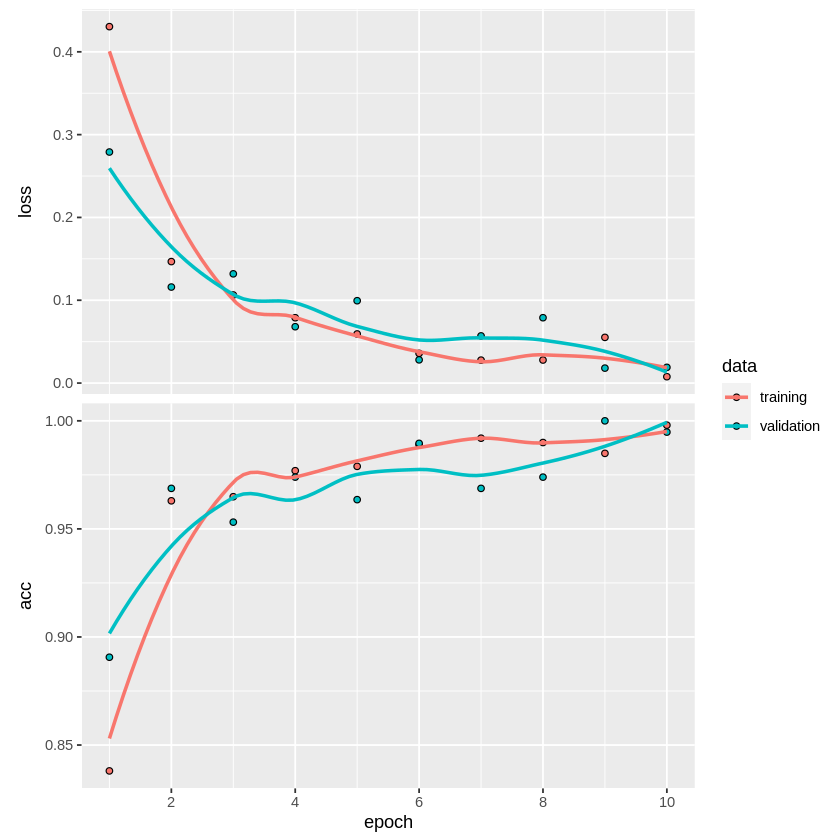

In [16]:
plot(history)

In [20]:
pdf("images/horses-humans-maroney2-acc-loss_.pdf", width = 8.03, height = 5.15748, paper = "special")
plot(history)
dev.off()

`geom_smooth()` using formula 'y ~ x'



png 
  2

In [18]:
history

Trained on 50 samples (batch_size=NULL, epochs=10)
Final epoch (plot to see history):
    loss: 0.007684
     acc: 0.998
val_loss: 0.01899
 val_acc: 0.9948 

## Evaluating results on the test set

In [ ]:
library(keras)
test.human.dir <- file.path(cur.dir, "data", "test", "humans")
test.horse.dir <- file.path(cur.dir,  "data", "test", "horses")

# load the model in a loop
# https://tensorflow.rstudio.com/tutorials/beginners/basic-ml/tutorial_save_and_restore/

results <- list(loss=c(), acc=c())
test.dir <- file.path(cur.dir, "data", "test")
# test.dir <- file.path(cur.dir, "data", "original-test")

models.fnames <- list.files(models.dir)
models.fnames <- paste0(file.path(models.dir, models.fnames))
for (i in 1:length(models.fnames)) {
  model <- load_model_hdf5(models.fnames[[i]])
  summary(model)
  test_datagen <- image_data_generator(rescale = 1/255)
  test_generator <- flow_images_from_directory(
    test.dir,
    test_datagen,
    target_size = c(300,300),
    batch_size = 20,
    class_mode = "binary"
  )
  models.results <- model %>% evaluate_generator( test_generator, steps = 50)
  results$loss <- c(results$loss, models.results$loss)
  results$acc <- c(results$acc, models.results$acc)
}

In [ ]:
results